In [27]:
import pandas as pd
import os
import random
import torch
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
import torch.nn.functional as F
!pip install torchinfo
from torchinfo import summary
!pip install torchmetrics
import torchmetrics
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h2>EXPLORATORY DATA ANALYSIS</h2>

In [190]:
csv_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"

# Checking for missing/incomplete data:
styles = pd.read_csv(csv_path, on_bad_lines="skip")
print("Number of samples before removing NAN's: ", len(styles))
styles.dropna(inplace=True)
print("Number of samples after removing NAN's: ", len(styles))

styles_required = pd.read_csv(csv_path, usecols=["id", "baseColour", "articleType", "season", "gender"]) # selecting columns that will be used as labels 
print("Number of incomplete labels: ", len(styles_required))
styles_required.dropna(inplace=True)
print("Number of labels after removing incomplete labels: ", len(styles_required))

styles.head(20)

Number of samples before removing NAN's:  44424
Number of samples after removing NAN's:  44077
Number of incomplete labels:  44446
Number of labels after removing incomplete labels:  44410


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


As there aren't many incomplete labels (44,446 - 44410 = 36) in comparision to the total dataset size, we can simply remove the rows which have NaN values.

In [191]:
# Display the number of unique classes in each column:
unique_counts = styles_required.nunique()

unique_values = {col: styles_required[col].unique() for col in styles_required.columns}

print("Number of unique categories per column:")
print(unique_counts)
print("\nUnique values per column:")
for col, values in unique_values.items():
    print(f"{col}: {values}")


Number of unique categories per column:
id             44410
gender             5
articleType      143
baseColour        46
season             4
dtype: int64

Unique values per column:
id: [15970 39386 59263 ... 18842 46694 51623]
gender: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']
articleType: ['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lipstick' 'Flats'
 'Kurtas' 'Waistcoat' 'Sports Shoes' 'Shorts' 'Briefs' 'Sarees'
 'Perfume and Body Mist' 'Heels' 'Sunglasses' 'Innerwear Vests' 'Pendant'
 'Nail Polish' 'Laptop Bag' 'Scarves' 'Rain Jacket' 'Dresses'
 'Night suits' 'Skirts' 'Wallets' 'Blazers' 'Ring' 'Kurta Sets' 'Clutches'
 'Shrug' 'Backpacks' 'Caps' 'Trousers' 'Earrings' 'Camisoles' 'Boxers'
 'Jewellery Set' 'Dupatta' 'Capris' 'Lip Gloss' 'Bath Robe' 'Mufflers'
 'Tunics' 'Jackets' 'Trunk' 'Lounge Pants' 'Face Wash and Cleanser'
 

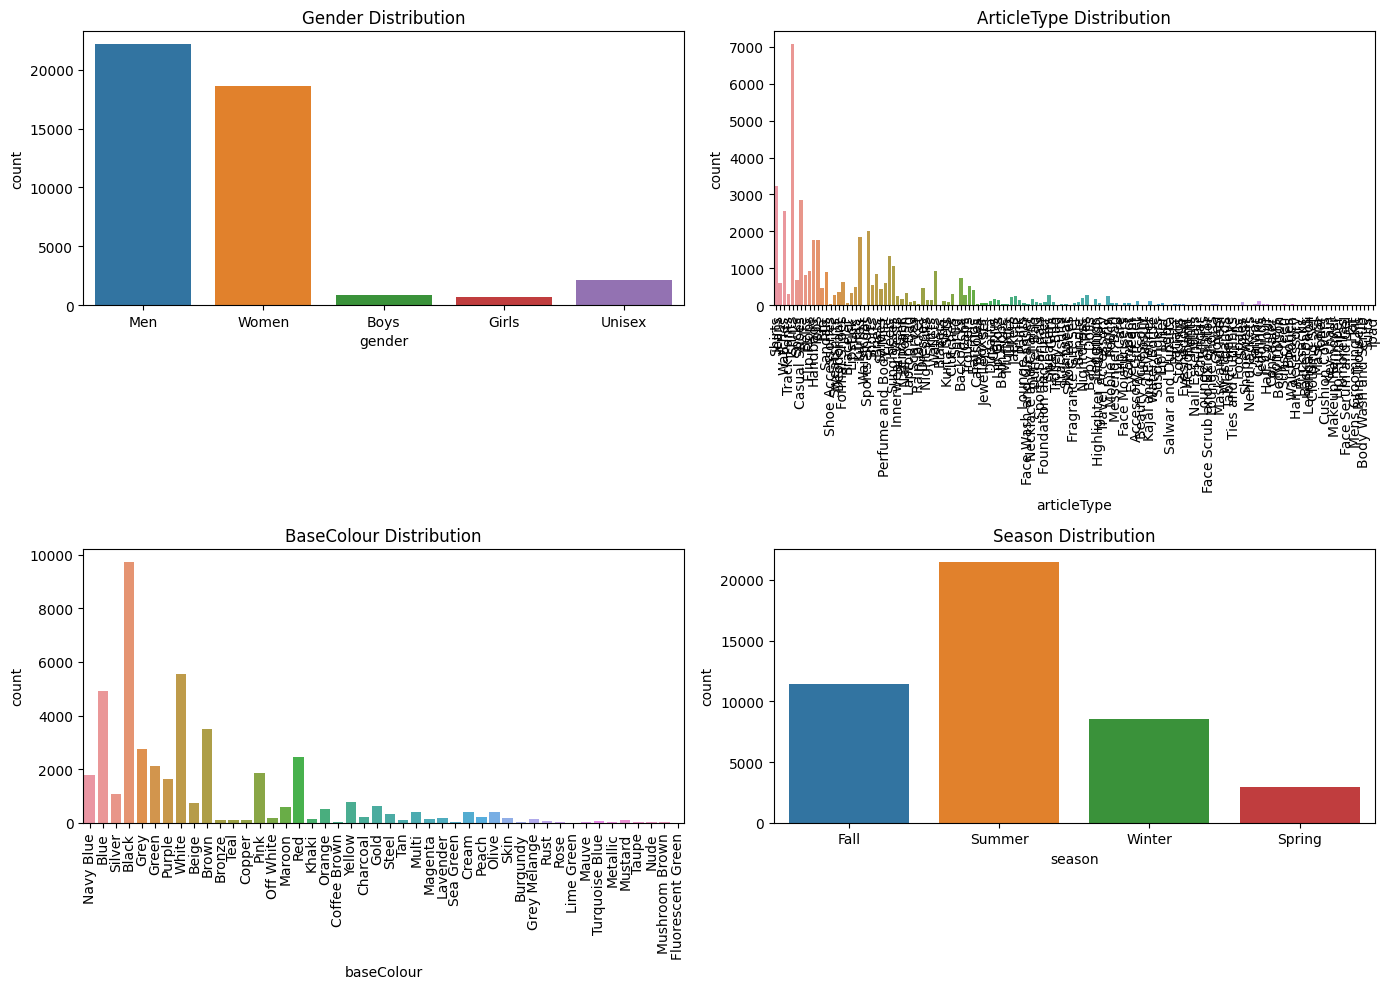

In [192]:
# Plot class frequencies for each category:

import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.countplot(x='gender', data=styles_required, ax=axs[0, 0])
axs[0, 0].set_title('Gender Distribution')

sns.countplot(x='articleType', data=styles_required, ax=axs[0, 1])
axs[0, 1].set_title('ArticleType Distribution')
axs[0, 1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

sns.countplot(x='baseColour', data=styles_required, ax=axs[1, 0])
axs[1, 0].set_title('BaseColour Distribution')
axs[1, 0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

sns.countplot(x='season', data=styles_required, ax=axs[1, 1])
axs[1, 1].set_title('Season Distribution')

plt.tight_layout()
plt.show()

In [193]:
# View number of examples in each class (men, women,...) for each category (gender, articleType,...):
pd.set_option('display.max_rows', None)

gender_counts = styles_required['gender'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']
print("Gender Distribution:\n", gender_counts)

articleType_counts = styles_required['articleType'].value_counts().reset_index()
articleType_counts.columns = ['ArticleType', 'Count']
print("\nArticleType Distribution:\n", articleType_counts)

baseColour_counts = styles_required['baseColour'].value_counts().reset_index()
baseColour_counts.columns = ['BaseColour', 'Count']
print("\nBaseColour Distribution:\n", baseColour_counts)

season_counts = styles_required['season'].value_counts().reset_index()
season_counts.columns = ['Season', 'Count']
print("\nSeason Distribution:\n", season_counts)

Gender Distribution:
    Gender  Count
0     Men  22146
1   Women  18621
2  Unisex   2158
3    Boys    830
4   Girls    655

ArticleType Distribution:
                    ArticleType  Count
0                      Tshirts   7069
1                       Shirts   3217
2                 Casual Shoes   2846
3                      Watches   2542
4                 Sports Shoes   2016
5                       Kurtas   1844
6                         Tops   1762
7                     Handbags   1759
8                        Heels   1323
9                   Sunglasses   1073
10                     Wallets    936
11                  Flip Flops    916
12                     Sandals    897
13                      Briefs    849
14                       Belts    813
15                   Backpacks    724
16                       Socks    686
17                Formal Shoes    637
18       Perfume and Body Mist    606
19                       Jeans    603
20                      Shorts    547
21          

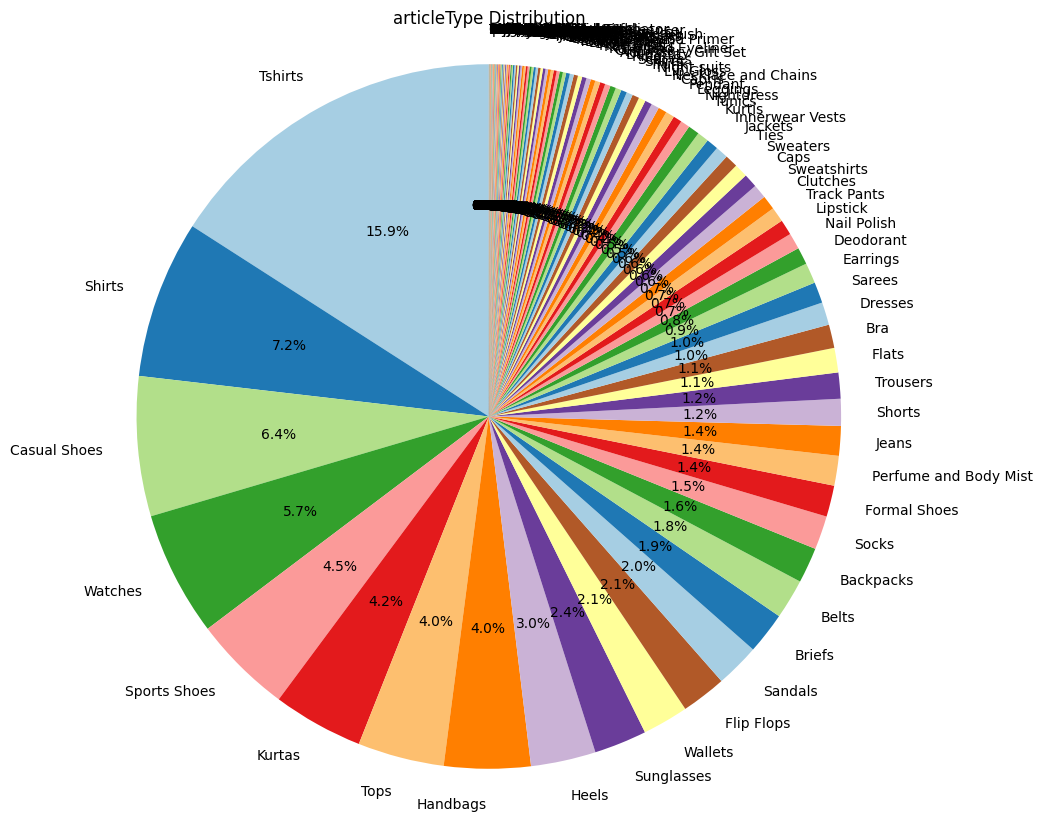

In [194]:
# Pie-chart on frequency distribution for classes in articleType
class_distribution = styles_required['articleType'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10, 10))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('articleType Distribution')
plt.axis('equal') 
plt.show()

articleType has 143 classes, but many of these classes have very few examples. It makes sense to remove these classes.

In [195]:
# Calculate the frequency of each class
class_distribution = styles_required['articleType'].value_counts()

# Calculate the percentage each class makes up of the total data
class_percentage = (class_distribution / class_distribution.sum()) * 100

# Filter classes that make up less than 0.3% of the data
classes_below_percent = class_percentage[class_percentage < 0.3]

# Get the number of such classes
num_classes_below_percent = len(classes_below_percent)

# Get the total number of examples falling in these classes
examples_below_percent = class_distribution[classes_below_percent.index].sum()

print(f"Number of classes making up less than 0.3% of the data: {num_classes_below_percent}")
print("Classes that make up less than 0.3% of the data:")
print(classes_below_percent)
print("Length:", len(classes_below_percent))
print(f"Total number of examples falling in these classes: {examples_below_percent}")

# Remove rows that belong to classes with less than 0.3% of the data:
styles_required_filtered = styles_required[~styles_required['articleType'].isin(classes_below_percent.index)]

# Output the result
print(f"Number of rows removed: {len(styles_required) - len(styles_required_filtered)}")
print(f"Number of rows remaining: {len(styles_required_filtered)}")
styles_required = styles_required_filtered 

Number of classes making up less than 0.3% of the data: 95
Classes that make up less than 0.3% of the data:
articleType
Skirts                       0.288223
Scarves                      0.267958
Ring                         0.265706
Dupatta                      0.261202
Accessory Gift Set           0.249944
Cufflinks                    0.238685
Kajal and Eyeliner           0.229678
Kurta Sets                   0.211664
Free Gifts                   0.204909
Stoles                       0.202657
Duffel Bag                   0.198154
Bangle                       0.191398
Laptop Bag                   0.184643
Foundation and Primer        0.171133
Sports Sandals               0.150867
Bracelet                     0.148615
Lounge Pants                 0.137356
Face Moisturisers            0.135105
Jewellery Set                0.130601
Fragrance Gift Set           0.128349
Highlighter and Blush        0.119342
Boxers                       0.117091
Compact                      0.110336
Lip Li

baseColour also has significant class imbalance, so colors that are similar can be grouped together to reduce the imbalance.

In [196]:
# Define the mapping of similar colors into broader categories
color_mapping = {
    'Black': ['Black', 'Charcoal'],
    'White': ['White', 'Off White', 'Cream', 'Beige'],
    'Blue': ['Blue', 'Navy Blue', 'Teal', 'Turquoise Blue'],
    'Brown': ['Brown', 'Khaki', 'Tan', 'Bronze', 'Copper', 'Skin', 'Coffee Brown', 'Nude', 'Mushroom Brown', 'Taupe'],
    'Grey': ['Grey', 'Steel', 'Grey Melange', 'Metallic', 'Silver'],
    'Red': ['Red', 'Maroon', 'Burgundy', 'Rose'],
    'Green': ['Green', 'Olive', 'Sea Green', 'Lime Green', 'Fluorescent Green'],
    'Pink': ['Pink', 'Peach'],
    'Purple': ['Purple', 'Lavender', 'Magenta', 'Mauve'],
    'Yellow': ['Yellow', 'Gold', 'Mustard'],
    'Orange': ['Orange', 'Rust'],
    'Multi': ['Multi']
}

# Function to group colors into main categories
def group_colors(base_colour):
    for main_color, similar_colors in color_mapping.items():
        if base_colour in similar_colors:
            return main_color
    return base_colour

styles_required['GroupedBaseColour'] = styles_required['baseColour'].apply(group_colors)

grouped_color_distribution = styles_required['GroupedBaseColour'].value_counts()

print(grouped_color_distribution)
styles_required.head()

styles_required['baseColour'] = styles_required['GroupedBaseColour']

styles_required.drop(columns=['GroupedBaseColour'], inplace=True)

print(styles_required.head())

GroupedBaseColour
Black     9389
Blue      6500
White     6496
Grey      3965
Brown     3831
Red       2912
Green     2385
Pink      1910
Purple    1832
Yellow    1333
Orange     537
Multi      348
Name: count, dtype: int64
      id gender  articleType baseColour  season
0  15970    Men       Shirts       Blue    Fall
1  39386    Men        Jeans       Blue  Summer
2  59263  Women      Watches       Grey  Winter
3  21379    Men  Track Pants      Black    Fall
4  53759    Men      Tshirts       Grey  Summer


Gender also has very few samples for 'Boy' and 'Girl', so 'Boy' can be mapped to 'Men' and 'Girl' can be mapped to 'Women'

In [197]:
gender_mapping = {
    'Men': ['Men', 'Boys'],
    'Women': ['Women', 'Girls'],
    'Unisex': ['Unisex'],
}

# Reverse mapping to make replacement easier
reverse_mapping = {}
for key, values in gender_mapping.items():
    for value in values:
        reverse_mapping[value] = key

# Apply the mapping to the gender column
styles_required['gender'] = styles_required['gender'].map(reverse_mapping)

# Display the number of unique classes in each column:
unique_counts = styles_required.nunique()

unique_values = {col: styles_required[col].unique() for col in styles_required.columns}

print("Number of unique categories per column:")
print(unique_counts)
print("\nUnique values per column:")
for col, values in unique_values.items():
    print(f"{col}: {values}")

Number of unique categories per column:
id             41438
gender             3
articleType       48
baseColour        12
season             4
dtype: int64

Unique values per column:
id: [15970 39386 59263 ... 18842 46694 51623]
gender: ['Men' 'Women' 'Unisex']
articleType: ['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Sweatshirts'
 'Deodorant' 'Formal Shoes' 'Lipstick' 'Flats' 'Kurtas' 'Sports Shoes'
 'Shorts' 'Briefs' 'Sarees' 'Perfume and Body Mist' 'Heels' 'Sunglasses'
 'Innerwear Vests' 'Pendant' 'Nail Polish' 'Dresses' 'Night suits'
 'Wallets' 'Clutches' 'Backpacks' 'Caps' 'Trousers' 'Earrings' 'Capris'
 'Lip Gloss' 'Tunics' 'Jackets' 'Trunk' 'Necklace and Chains' 'Sweaters'
 'Nightdress' 'Ties' 'Leggings' 'Kurtis']
baseColour: ['Blue' 'Grey' 'Black' 'Green' 'Purple' 'White' 'Brown' 'Pink' 'Red'
 'Yellow' 'Orange' 'Multi']
season: ['Fall' 'Summer' 'Winter' 'Spring']


In [198]:
# View number of examples in each class (men, women,...) for each category (gender, articleType,...) for filtered data:
pd.set_option('display.max_rows', None)

gender_counts = styles_required['gender'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']
print("Gender Distribution:\n", gender_counts)

articleType_counts = styles_required['articleType'].value_counts().reset_index()
articleType_counts.columns = ['ArticleType', 'Count']
print("\nArticleType Distribution:\n", articleType_counts)

baseColour_counts = styles_required['baseColour'].value_counts().reset_index()
baseColour_counts.columns = ['BaseColour', 'Count']
print("\nBaseColour Distribution:\n", baseColour_counts)

season_counts = styles_required['season'].value_counts().reset_index()
season_counts.columns = ['Season', 'Count']
print("\nSeason Distribution:\n", season_counts)

Gender Distribution:
    Gender  Count
0     Men  22227
1   Women  17380
2  Unisex   1831

ArticleType Distribution:
               ArticleType  Count
0                 Tshirts   7069
1                  Shirts   3217
2            Casual Shoes   2846
3                 Watches   2542
4            Sports Shoes   2016
5                  Kurtas   1844
6                    Tops   1762
7                Handbags   1759
8                   Heels   1323
9              Sunglasses   1073
10                Wallets    936
11             Flip Flops    916
12                Sandals    897
13                 Briefs    849
14                  Belts    813
15              Backpacks    724
16                  Socks    686
17           Formal Shoes    637
18  Perfume and Body Mist    606
19                  Jeans    603
20                 Shorts    547
21               Trousers    530
22                  Flats    500
23                    Bra    477
24                Dresses    464
25                 Saree

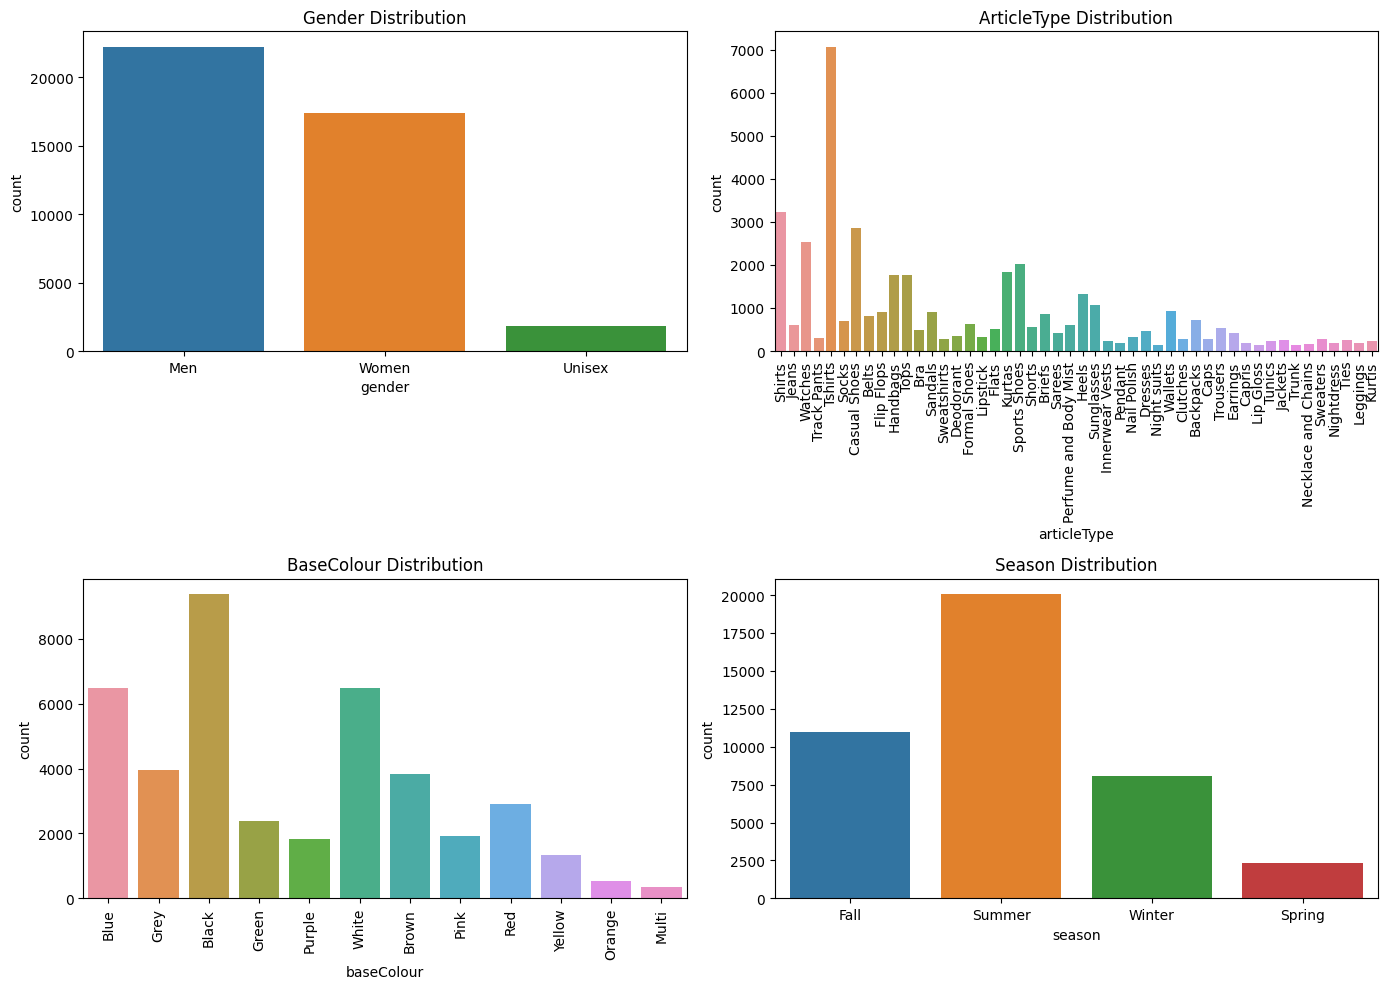

In [199]:
# Plot class frequencies for each category:

import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.countplot(x='gender', data=styles_required, ax=axs[0, 0])
axs[0, 0].set_title('Gender Distribution')

sns.countplot(x='articleType', data=styles_required, ax=axs[0, 1])
axs[0, 1].set_title('ArticleType Distribution')
axs[0, 1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

sns.countplot(x='baseColour', data=styles_required, ax=axs[1, 0])
axs[1, 0].set_title('BaseColour Distribution')
axs[1, 0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

sns.countplot(x='season', data=styles_required, ax=axs[1, 1])
axs[1, 1].set_title('Season Distribution')

plt.tight_layout()
plt.show()

These class distributions are less unbalanced than before filtering.

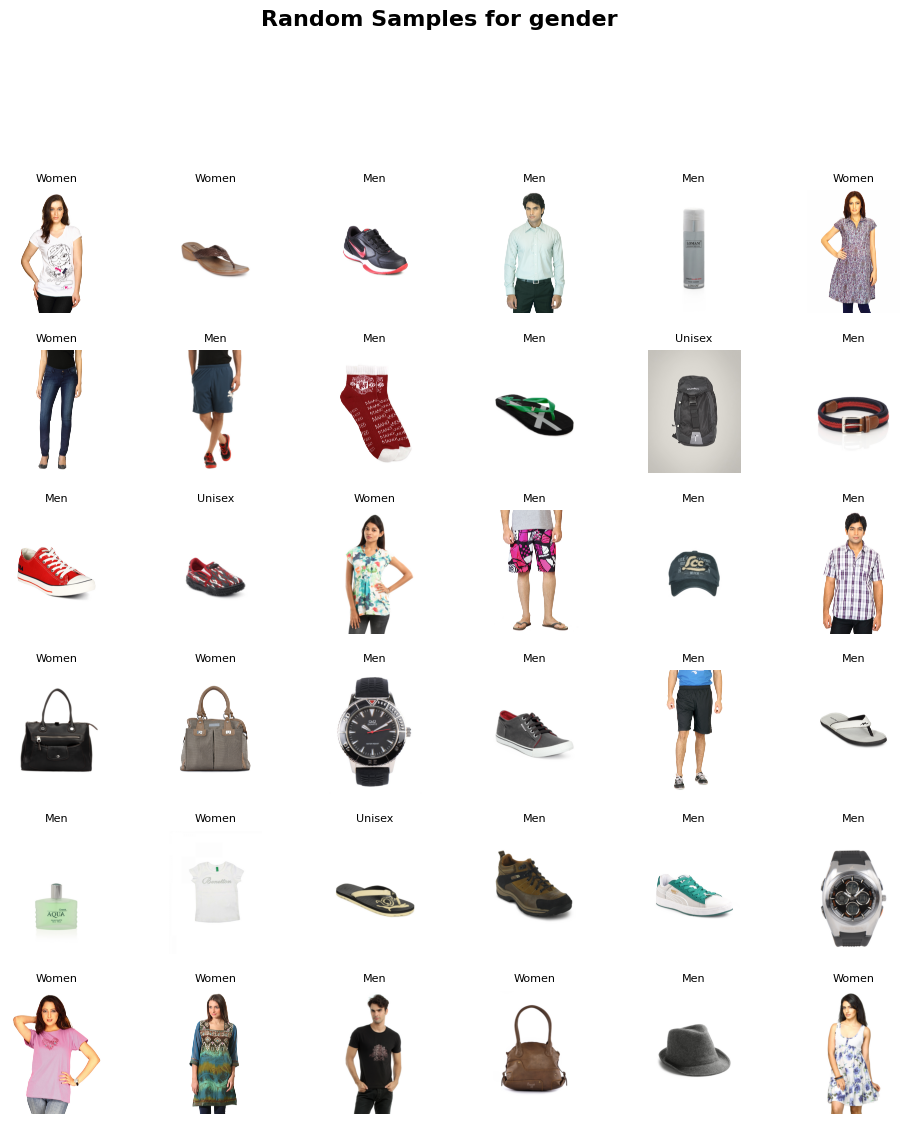

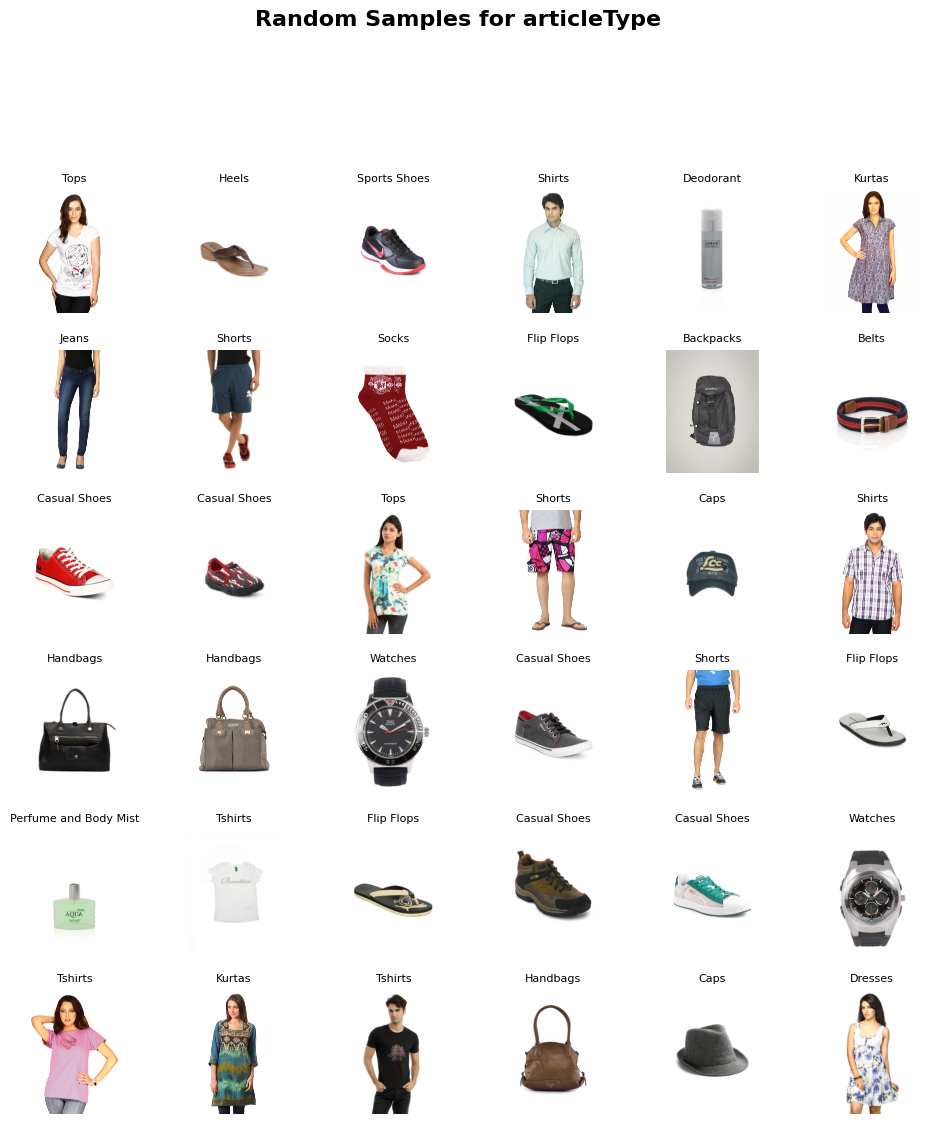

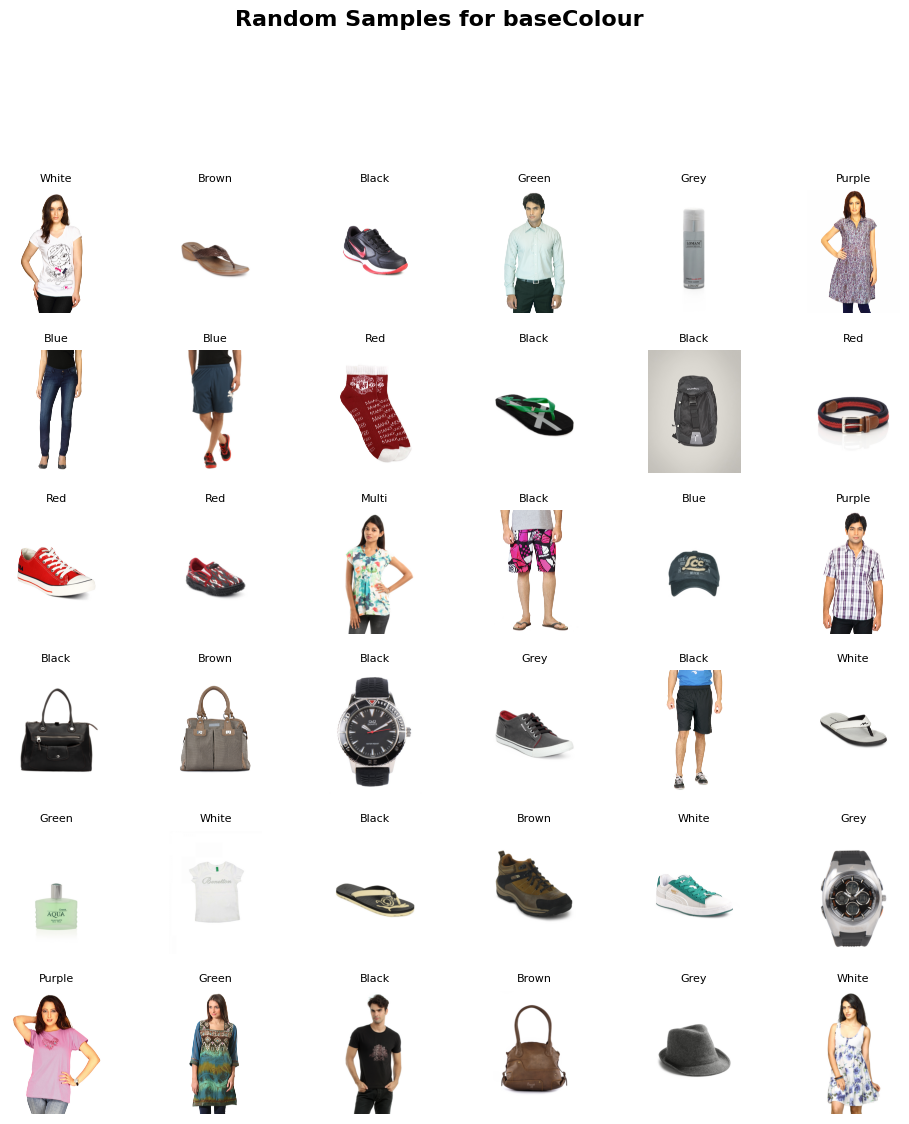

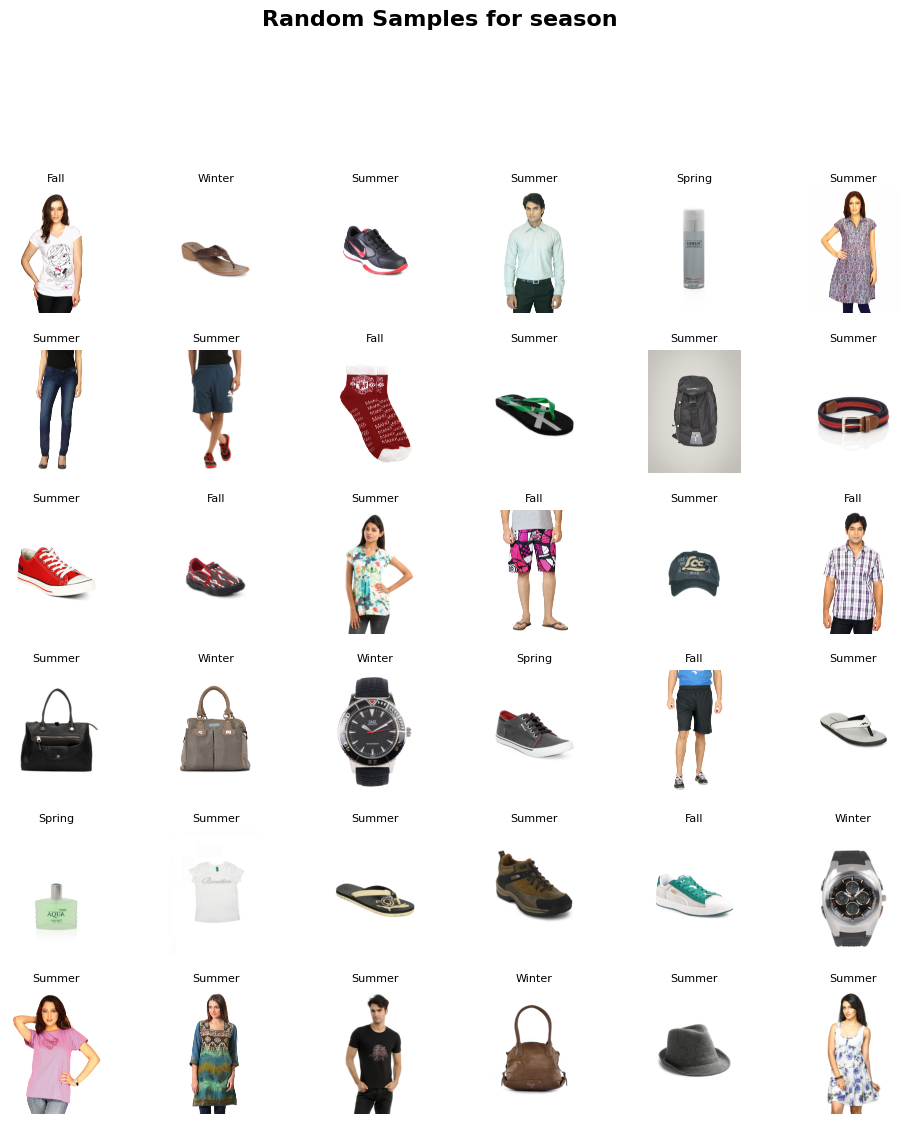

In [84]:
def plot_random_samples(df, column_name, image_base_dir, num_samples=36):
    
    sampled_df = df.sample(n=num_samples, random_state=11)
    
    fig, axes = plt.subplots(6, 6, figsize=(12, 12)) 
    axes = axes.flatten()
    
    for i, (idx, row) in enumerate(sampled_df.iterrows()):
        # Construct the image path using the 'id' column
        img_path = os.path.join(image_base_dir, f"{row['id']}.jpg")
        
        # Load the image from the constructed path
        img = plt.imread(img_path)
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes
        
        # Set the class label below the image
        axes[i].set_title(f"{row[column_name]}", fontsize=8)  # Reduced fontsize for smaller labels

    # Add a title to the entire plot for the specific column/category
    fig.suptitle(f"Random Samples for {column_name}", fontsize=16, fontweight='bold', y=1.03)

    # Adjust layout to reduce space between subplots
    plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust horizontal and vertical spacing
    plt.show()

# Path to the directory containing images
image_base_dir = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'

# Plot random samples for each of the columns with category titles
plot_random_samples(styles_required, 'gender', image_base_dir)
plot_random_samples(styles_required, 'articleType', image_base_dir)
plot_random_samples(styles_required, 'baseColour', image_base_dir)
plot_random_samples(styles_required, 'season', image_base_dir)

In [200]:
# Creating class indices for each column 
from sklearn.preprocessing import LabelEncoder

label_encoders = {}  # Store encoders for later inverse transform
for col in ["gender", "articleType", "baseColour", "season"]:
    le = LabelEncoder()
    styles_required[col] = le.fit_transform(styles_required[col])  # Assigns unique integers
    label_encoders[col] = le  # Save encoder

print(styles_required.head(),'\n', len(styles_required))

labels_array = styles_required.to_numpy(dtype=int)
labels = torch.tensor(labels_array, dtype=torch.int64) 
print(labels[0:5,:], '\n\n', labels.shape)

      id  gender  articleType  baseColour  season
0  15970       0           32           1       0
1  39386       0           18           1       2
2  59263       2           47           4       3
3  21379       0           41           0       0
4  53759       0           44           4       2 
 41438
tensor([[15970,     0,    32,     1,     0],
        [39386,     0,    18,     1,     2],
        [59263,     2,    47,     4,     3],
        [21379,     0,    41,     0,     0],
        [53759,     0,    44,     4,     2]]) 

 torch.Size([41438, 5])


In [201]:
# Get unique values count for each column
unique_counts = styles_required.nunique()

unique_values = {col: styles_required[col].unique() for col in styles_required.columns}

print("Number of unique categories per column:")
print(unique_counts)
print("\nUnique values per column:")
for col, values in unique_values.items():
    print(f"{col}: {values}")


Number of unique categories per column:
id             41438
gender             3
articleType       48
baseColour        12
season             4
dtype: int64

Unique values per column:
id: [15970 39386 59263 ... 18842 46694 51623]
gender: [0 2 1]
articleType: [32 18 47 41 44 34  6  1 12 14 40  2 30 38  8 13 23 11 19 35 33  3 31 29
 15 36 16 28 24  9 26 46  7  0  5 42 10  4 22 45 17 43 25 37 27 39 21 20]
baseColour: [ 1  4  0  3  8 10  2  7  9 11  6  5]
season: [0 2 3 1]


In [202]:
images_folder = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'
image_filenames = os.listdir(images_folder)

# Remove images that don't have corresponding labels
image_ids_in_labels = torch.tensor(labels[:, 0], dtype=torch.int)
image_filenames = [image_file for image_file in image_filenames 
                   if int(image_file.split(".")[0]) in image_ids_in_labels.tolist()]

# Sort image filenames by ID
image_filenames.sort(key=lambda x: int(x.split(".")[0]))
print(f"Number of images after filtering: {len(image_filenames)}")

# Remove labels that don't have corresponding images
image_ids = [int(image_file.split(".")[0]) for image_file in image_filenames]
labels = labels[torch.isin(labels[:, 0], torch.tensor(image_ids))]

# Sort the labels by ID
labels = labels[labels[:, 0].argsort()]
print(f"Number of labels after filtering: {labels.shape[0]}")

# Check if image_filenames and labels are both arranged the same way
ids_from_images = [int(filename.split(".")[0]) for filename in image_filenames]
ids_from_labels = labels[:, 0].tolist()

if ids_from_images == ids_from_labels:
    print("Both lists are the same.")
else:
    print("Lists are different.")

<ipython-input-202-7c4eacae0ee4>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_ids_in_labels = torch.tensor(labels[:, 0], dtype=torch.int)


Number of images after filtering: 41434
Number of labels after filtering: 41434
Both lists are the same.


In [203]:
class FashionDataset(Dataset):
    def __init__(self, image_dir, image_filenames, labels, transform=None):
        self.image_filenames = image_filenames
        self.image_dir = image_dir
        self.labels = labels
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx,-4:]

        return image, label


During initial experiments, the commented transforms in the cell below were passed as an argument to the FashionDataset class, but the process of resizing and normalizing the images while training required significant time. In order to speed up training, the transforms were applied to each image, and the transformed image was copied and saved to a separate folder. This folder containing the transformed files is referred to later on as: transformed_images_folder. The model was trained using the images from the transformed_images_folder. 

By removing the resizing and normalization step, training time per batch was reduced threefold.

In [8]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  
#     transforms.ToTensor(),  
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
# ])

# # Creating new image dataset with transformed images to reduce training time:
# transformed_imgs_folder = "/kaggle/working/transformed_imgs"
# os.makedirs(transformed_imgs_folder, exist_ok=True)

# for img_name in tqdm(image_filenames, desc="Processing Images", unit="image"):
#     img_path = os.path.join(images_folder, img_name)
#     img = Image.open(img_path).convert("RGB")
#     transformed_img = transform(img)
    
#     # Convert tensor back to PIL image and save
#     transformed_pil = transforms.ToPILImage()(transformed_img)
#     transformed_pil.save(os.path.join(transformed_imgs_folder, img_name))

Processing Images: 100%|██████████| 44405/44405 [41:06<00:00, 18.01image/s]  


In [204]:
# Loading an image to determine shape after passing through backbone model
pic_path = os.path.join(images_folder, image_filenames[10000])
pic = Image.open(pic_path).convert("RGB")
tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
pic = tf(pic)
print(pic.shape)


torch.Size([3, 224, 224])


<h2>MODEL</h2>

In [205]:
# EfficientNet backbone:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
bb1 = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
bb1 = nn.Sequential(*list(bb1.children())[:-1], nn.Flatten())
pred = bb1(pic.unsqueeze(0))
print(summary(bb1))
print(pred.shape)

Layer (type:depth-idx)                                  Param #
Sequential                                              --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 6,004
│    │    └─MBConv: 3-6                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 15,350
│    │    └─MBConv: 3-8                                 31,290
│    └─Sequential: 2-5                                  --
│    │    └─MBConv: 3-9         

In [206]:
class FashionProductClassifier(nn.Module):
    def __init__(self, backbone, backbone_features, num_classes, dropout_prob=0.5):
        super(FashionProductClassifier, self).__init__()
        self.backbone = backbone

        self.dropout = nn.Dropout(p=dropout_prob)

        # Separate classifier heads for each category
        self.gender_head = nn.Linear(backbone_features, num_classes["gender"])
        self.articleType_head = nn.Linear(backbone_features, num_classes["articleType"])
        self.baseColour_head = nn.Linear(backbone_features, num_classes["baseColour"])
        self.season_head = nn.Linear(backbone_features, num_classes["season"])

    def forward(self, x):
        features = self.backbone(x)
        features = self.dropout(features)
        
        gender_out = self.gender_head(features)
        articleType_out = self.articleType_head(features)
        baseColour_out = self.baseColour_head(features)
        season_out = self.season_head(features)

        return {
            "baseColour": baseColour_out,
            "articleType": articleType_out,
            "season": season_out,
            "gender": gender_out,
        }

In [207]:
num_classes = {
    "gender": 3,
    "articleType": 48,
    "baseColour": 12,
    "season": 4
}

# Model
model = FashionProductClassifier(bb1, 1280, num_classes) # using EfficientNet backbone
model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)
print(summary(model))

Layer (type:depth-idx)                                            Param #
DataParallel                                                      --
├─FashionProductClassifier: 1-1                                   --
│    └─Sequential: 2-1                                            --
│    │    └─Sequential: 3-1                                       4,007,548
│    │    └─AdaptiveAvgPool2d: 3-2                                --
│    │    └─Flatten: 3-3                                          --
│    └─Dropout: 2-2                                               --
│    └─Linear: 2-3                                                3,843
│    └─Linear: 2-4                                                61,488
│    └─Linear: 2-5                                                15,372
│    └─Linear: 2-6                                                5,124
Total params: 4,093,375
Trainable params: 4,093,375
Non-trainable params: 0


<h2>TRAINING</h2>

In [208]:
# Function to calculate weights for each class for weighted CrossEntropy loss, to help address some of the class imbalance:
def calculate_class_weights(labels: torch.Tensor, num_classes: int) -> torch.Tensor: 
    total_samples = labels.shape[0]
    
    # Count the number of samples per class
    class_counts = torch.bincount(labels, minlength=num_classes).float()
    #print(class_counts)
    #print(total_samples)
    weights = total_samples / (num_classes * class_counts)
    weights = weights / weights.sum() * num_classes #normalize so sum of weights = no. of classes
    
    return weights

Stratified sampling is used to build the training, validation and test sets in order to ensure the distribution of each class remains similar for all the 3 sets.

In [209]:
# HYPERPARAMETERS:
LR = 0.0001
EPOCHS = 3
start_epoch = 0    # used for resuming training from checkpoint
BATCH_SIZE = 64
weight_decay = 0.0001
num_workers = 4
category_weights = {
    "gender": 0.05,
    "articleType": 0.05,
    "baseColour": 0.7,
    "season": 0.2
} # used to weight each task when computing total loss, so model doesn't focus on easy tasks (like season) & ignore harder tasks (like articleType)


# Dataloaders using stratified sampling:
from sklearn.model_selection import StratifiedShuffleSplit

transformed_images_folder = '/kaggle/input/transformed-imgs-224-224/kaggle/working/transformed_imgs'
transform = transforms.Compose([transforms.ToTensor()])

article_type_labels = labels[:, -3]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(splitter.split(np.zeros(len(labels)), article_type_labels))

val_test_labels = article_type_labels[temp_idx]
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter2.split(np.zeros(len(temp_idx)), val_test_labels))
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

dataset = FashionDataset(transformed_images_folder, image_filenames, labels, transform=transform)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)


# Loss function and optimizer
gender_weights = calculate_class_weights(labels[:, -4], 3).to(device)
articleType_weights = calculate_class_weights(labels[:, -3], 48).to(device)
baseColour_weights = calculate_class_weights(labels[:, -2], 12).to(device)
season_weights = calculate_class_weights(labels[:, -1], 4).to(device)

print("Gender Class Weights:", gender_weights)
print("ArticleType Class Weights:", articleType_weights)
print("BaseColour Class Weights:", baseColour_weights)
print("Season Class Weights:", season_weights)

gender_loss = torch.nn.CrossEntropyLoss(weight=gender_weights) 
article_loss = torch.nn.CrossEntropyLoss(weight=articleType_weights) 
colour_loss = torch.nn.CrossEntropyLoss(weight=baseColour_weights) 
season_loss = torch.nn.CrossEntropyLoss(weight=season_weights) 

loss_fns = {
    "gender": gender_loss,
    "articleType": article_loss,
    "baseColour": colour_loss,
    "season": season_loss
}
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=weight_decay)


# Checkpoints:
checkpoint_path = "/kaggle/working/checkpt_model.pth"
checkpoint_load_path = "/kaggle/working/checkpt_model.pth"

Gender Class Weights: tensor([0.2081, 2.5258, 0.2661], device='cuda:0')
ArticleType Class Weights: tensor([0.5105, 0.4546, 0.7748, 0.4353, 2.1120, 1.3060, 0.1299, 1.2745, 1.0651,
        0.7965, 0.8863, 0.7392, 0.4035, 0.5802, 0.2101, 0.2794, 1.5272, 1.4325,
        0.6139, 0.2004, 1.5795, 2.0881, 2.5666, 1.1733, 1.1234, 2.3100, 2.6212,
        1.9555, 2.1000, 0.6099, 0.4120, 0.8656, 0.1150, 0.6757, 0.5388, 0.1833,
        0.3444, 1.3343, 1.2968, 1.4053, 0.2098, 1.2158, 0.6973, 2.6400, 0.0523,
        1.6139, 0.3949, 0.1454], device='cuda:0')
BaseColour Class Weights: tensor([0.1550, 0.2239, 0.3799, 0.6102, 0.3670, 4.1819, 2.7100, 0.7619, 0.7944,
        0.4999, 0.2241, 1.0917], device='cuda:0')
Season Class Weights: tensor([0.5246, 2.4799, 0.2861, 0.7094], device='cuda:0')


In [67]:
print(label_encoders['baseColour'].classes_)

['Black' 'Blue' 'Brown' 'Green' 'Grey' 'Multi' 'Orange' 'Pink' 'Purple'
 'Red' 'White' 'Yellow']


The weights match up with the class frequencies, 'Multi' has the lowest number of samples, and has the highest weight (4.1819).

In [68]:
# Gender metrics (5 classes):
gender_accuracy = torchmetrics.Accuracy(task="multiclass", average="macro", num_classes=3).to(device)
gender_precision = torchmetrics.Precision(task="multiclass", average="macro", num_classes=3).to(device)
gender_recall = torchmetrics.Recall(task="multiclass", average="macro", num_classes=3).to(device)
gender_f1 = torchmetrics.F1Score(task="multiclass", average="macro", num_classes=3).to(device)

# ArticleType metrics (48 classes):
articleType_accuracy = torchmetrics.Accuracy(task="multiclass", average="macro", num_classes=48).to(device)
articleType_precision = torchmetrics.Precision(task="multiclass", average="macro", num_classes=48).to(device)
articleType_recall = torchmetrics.Recall(task="multiclass", average="macro", num_classes=48).to(device)
articleType_f1 = torchmetrics.F1Score(task="multiclass", average="macro", num_classes=48).to(device)

# BaseColour metrics (12 classes):
baseColour_accuracy = torchmetrics.Accuracy(task="multiclass", average="macro", num_classes=12).to(device)
baseColour_precision = torchmetrics.Precision(task="multiclass", average="macro", num_classes=12).to(device)
baseColour_recall = torchmetrics.Recall(task="multiclass", average="macro", num_classes=12).to(device)
baseColour_f1 = torchmetrics.F1Score(task="multiclass", average="macro", num_classes=12).to(device)

# Season metrics (4 classes):
season_accuracy = torchmetrics.Accuracy(task="multiclass", average="macro", num_classes=4).to(device)
season_precision = torchmetrics.Precision(task="multiclass", average="macro", num_classes=4).to(device)
season_recall = torchmetrics.Recall(task="multiclass", average="macro", num_classes=4).to(device)
season_f1 = torchmetrics.F1Score(task="multiclass", average="macro", num_classes=4).to(device)

# Organizing metrics in a list:
gender_metrics = [
    gender_accuracy,
    gender_precision,
    gender_recall,
    gender_f1
]

articleType_metrics = [
    articleType_accuracy,
    articleType_precision,
    articleType_recall,
    articleType_f1
]

baseColour_metrics = [
    baseColour_accuracy,
    baseColour_precision,
    baseColour_recall,
    baseColour_f1
]

season_metrics = [
    season_accuracy,
    season_precision,
    season_recall,
    season_f1
]

In [69]:
def train(trainloader, model, loss_fns, category_weights, optimizer, gender_metrics, articleType_metrics, baseColour_metrics, season_metrics):
    model.train()

    # Reset metrics
    for metric in gender_metrics + articleType_metrics + baseColour_metrics + season_metrics:
        metric.reset()
    
    total_loss = 0
    
    for input, label in tqdm(trainloader, desc="Training", unit="batch"):
        optimizer.zero_grad()
        
        input, label = input.to(device, non_blocking=True), label.to(device, non_blocking=True)

        pred = model(input)

        loss = (
            category_weights["gender"] * loss_fns["gender"](pred["gender"], label[:, -4]) +
            category_weights["articleType"] * loss_fns["articleType"](pred["articleType"], label[:, -3]) +
            category_weights["baseColour"] * loss_fns["baseColour"](pred["baseColour"], label[:, -2]) +
            category_weights["season"] * loss_fns["season"](pred["season"], label[:, -1])
        )
        total_loss += loss.item()

        loss.backward()
        
        optimizer.step()

        # Update metrics
        for metric in gender_metrics:
            metric.update(pred["gender"], label[:, -4])
        for metric in articleType_metrics:
            metric.update(pred["articleType"], label[:, -3])
        for metric in baseColour_metrics:
            metric.update(pred["baseColour"], label[:, -2])
        for metric in season_metrics:
            metric.update(pred["season"], label[:, -1])

    # Compute loss for entire epoch:
    epoch_loss = total_loss / len(trainloader)

    final_metrics = {
        "gender": [metric.compute().item() for metric in gender_metrics],
        "articleType": [metric.compute().item() for metric in articleType_metrics],
        "baseColour": [metric.compute().item() for metric in baseColour_metrics],
        "season": [metric.compute().item() for metric in season_metrics]
    }

    return epoch_loss, final_metrics

In [70]:
def test(testloader, model, loss_fns, category_weights, gender_metrics, articleType_metrics, baseColour_metrics, season_metrics):
    model.eval() 

    for metric in gender_metrics + articleType_metrics + baseColour_metrics + season_metrics:
        metric.reset()

    total_loss = 0

    with torch.no_grad(): 
        for input, label in tqdm(testloader, desc="Testing", unit="batch"):
            input, label = input.to(device, non_blocking=True), label.to(device, non_blocking=True)

            pred = model(input)

            loss = (
                category_weights["gender"] * loss_fns["gender"](pred["gender"], label[:, -4]) +
                category_weights["articleType"] * loss_fns["articleType"](pred["articleType"], label[:, -3]) +
                category_weights["baseColour"] * loss_fns["baseColour"](pred["baseColour"], label[:, -2]) +
                category_weights["season"] * loss_fns["season"](pred["season"], label[:, -1])
            )
            total_loss += loss.item()

            for metric in gender_metrics:
                metric.update(pred["gender"], label[:, -4])
            for metric in articleType_metrics:
                metric.update(pred["articleType"], label[:, -3])
            for metric in baseColour_metrics:
                metric.update(pred["baseColour"], label[:, -2])
            for metric in season_metrics:
                metric.update(pred["season"], label[:, -1])

    final_metrics = {
        "gender": [metric.compute().item() for metric in gender_metrics],
        "articleType": [metric.compute().item() for metric in articleType_metrics],
        "baseColour": [metric.compute().item() for metric in baseColour_metrics],
        "season": [metric.compute().item() for metric in season_metrics]
    }

    epoch_loss = total_loss / len(testloader)  # Avoid division by zero
    
    return epoch_loss, final_metrics

In [71]:
def log_metrics(epoch, epoch_loss, final_metrics, log_file="fmodel.csv"):
    log_entry = [
        epoch + 1,  # Epoch (1-based index)
        epoch_loss,  # Total Loss
        *final_metrics["gender"],  
        *final_metrics["articleType"],  
        *final_metrics["baseColour"],  
        *final_metrics["season"],  
    ]

    columns = [
        "Epoch", "Total Loss",  
        "Gender Accuracy", "Gender Precision", "Gender Recall", "Gender F1",  
        "ArticleType Accuracy", "ArticleType Precision", "ArticleType Recall", "ArticleType F1",  
        "BaseColour Accuracy", "BaseColour Precision", "BaseColour Recall", "BaseColour F1",  
        "Season Accuracy", "Season Precision", "Season Recall", "Season F1"
    ]

    log_df = pd.DataFrame([log_entry], columns=columns)
    log_df.to_csv(log_file, mode='a', header=not pd.io.common.file_exists(log_file), index=False)


def initialize_log_file(log_file):
    if not os.path.exists(log_file):
        log_df = pd.DataFrame(columns=[
            "Epoch", "Total Loss",  
            "Gender Accuracy", "Gender Precision", "Gender Recall", "Gender F1",  
            "ArticleType Accuracy", "ArticleType Precision", "ArticleType Recall", "ArticleType F1",  
            "BaseColour Accuracy", "BaseColour Precision", "BaseColour Recall", "BaseColour F1",  
            "Season Accuracy", "Season Precision", "Season Recall", "Season F1"
        ])
        log_df.to_csv(log_file, index=False)

In [72]:
# Initialize log file:
train_log_file = "train_log.csv"
test_log_file = "test_log.csv"
initialize_log_file(train_log_file)
initialize_log_file(test_log_file)

# Load checkpoint:
if os.path.exists(checkpoint_load_path):
    checkpoint = torch.load(checkpoint_load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")


# TRAINING LOOP:
prev_val_loss = 0 
for epoch in range(start_epoch, EPOCHS):
    print(f"Epoch {epoch + 1}")
    print("-" * 10)

    train_loss, train_metrics = train(trainloader, model, loss_fns, category_weights, optimizer, gender_metrics, articleType_metrics, baseColour_metrics, season_metrics)
    log_metrics(epoch, train_loss, train_metrics, log_file=train_log_file)

    val_loss, val_metrics = test(val_loader, model, loss_fns, category_weights, gender_metrics, articleType_metrics, baseColour_metrics, season_metrics)
    log_metrics(epoch, val_loss, val_metrics, log_file=test_log_file)
    
    print("TrainLoss: ", train_loss, " TestLoss: ", val_loss)

    if epoch == 0:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss}, checkpoint_path)
        print("Checkpoint saved.")
    if val_loss < prev_val_loss:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss}, checkpoint_path)
        print("Checkpoint saved.")

    prev_val_loss = val_loss



Epoch 1
----------


Testing: 100%|██████████| 98/98 [00:14<00:00,  6.82batch/s]


TrainLoss:  0.482440661163057  TestLoss:  1.1110047898730453
Checkpoint saved.
Epoch 2
----------


Testing: 100%|██████████| 98/98 [00:14<00:00,  6.92batch/s]


TrainLoss:  0.44555214651355657  TestLoss:  1.1219012795054182
Epoch 3
----------


Testing: 100%|██████████| 98/98 [00:14<00:00,  6.79batch/s]

TrainLoss:  0.41337624215213215  TestLoss:  1.1658157040270007


<h2>EVALUATION</h2>

In [73]:
test_loss, test_metrics = test(test_loader, model, loss_fns, category_weights, gender_metrics, articleType_metrics, baseColour_metrics, season_metrics)

Testing: 100%|██████████| 98/98 [00:14<00:00,  6.68batch/s]


In [78]:
metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score"]

print(f"\nTest Loss: {test_loss:.4f}")
print(f"{'Category':<15} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
print("-" * 65)

for category, scores in test_metrics.items():
    print(f"{category:<15} | "
          f"{scores[0]:<10.4f} | "
          f"{scores[1]:<10.4f} | "
          f"{scores[2]:<10.4f} | "
          f"{scores[3]:<10.4f}")



Test Loss: 1.0867
Category        | Accuracy   | Precision  | Recall     | F1-Score  
-----------------------------------------------------------------
gender          | 0.8897     | 0.7622     | 0.8897     | 0.7933    
articleType     | 0.9014     | 0.8394     | 0.9014     | 0.8587    
baseColour      | 0.6396     | 0.6088     | 0.6396     | 0.6197    
season          | 0.7483     | 0.6701     | 0.7483     | 0.6988    


Checkpoint loaded.


<ipython-input-120-64efa9e762ce>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_load_path)


Predictions: {'gender': 'Men', 'articleType': 'Formal Shoes', 'baseColour': 'Brown', 'season': 'Spring'}


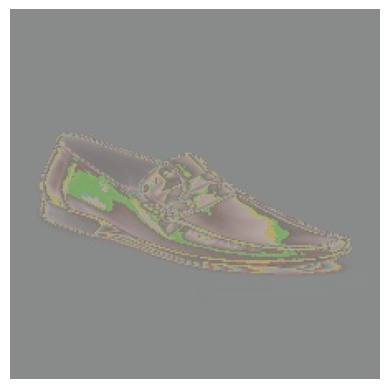

In [120]:
# Viewing prediction on random image from test set:
checkpoint = torch.load(checkpoint_load_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1
print(f"Checkpoint loaded.")

# Set model to eval mode
model.eval()

# Get one batch from test loader
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Pick a random index within the batch
rand_idx = random.randint(0, len(images) - 1)

# Get the image and label
img = images[rand_idx].unsqueeze(0).to(device)  # Add batch dimension & move to device

# Forward pass through model
with torch.no_grad():
    outputs = model(img)
    preds = { 
        "gender": torch.argmax(outputs["gender"], dim=1).item(),
        "articleType": torch.argmax(outputs["articleType"], dim=1).item(),
        "baseColour": torch.argmax(outputs["baseColour"], dim=1).item(),
        "season": torch.argmax(outputs["season"], dim=1).item()
    }

# OPTIONAL: Decode labels using label_encoders
decoded_preds = {}
for key in preds:
    decoded_preds[key] = label_encoders[key].inverse_transform([preds[key]])[0]

print("Predictions:", decoded_preds)

# Plot image
img_np = images[rand_idx].permute(1, 2, 0).cpu().numpy()  # Convert to HWC
# Unnormalize (reverse transform if needed)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img_np = std * img_np + mean
img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.axis('off')
plt.show()



<h2>PREDICTIONS WITH IMAGES FROM AMAZON</h2>

When I created the new dataset with the transforms applied on the images, I had saved the images using PIL. To ensure that the prediction images undergo the same process before prediction, I have opened them, applied the transforms, saved them as PIL to an intermediate folder, and finally opened them and applied the same transforms passed to the FashionDataset class.

In [176]:
# Folder & transform setup
prediction_imgs_folder = '/kaggle/input/pred-imgs-amazon/prediction_imgs'
image_paths = [os.path.join(prediction_imgs_folder, img) for img in os.listdir(prediction_imgs_folder)]
img_names = os.listdir(prediction_imgs_folder)

intermediate_folder = "/kaggle/working/intermediate"
os.makedirs(intermediate_folder, exist_ok=True)

prediction_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

model_transform = transforms.Compose([transforms.ToTensor()])

for i, img_path in enumerate(image_paths):
    # Load image
    img = Image.open(img_path).convert('RGB')
    transformed_img = prediction_transforms(img)
    
    transformed_pil = transforms.ToPILImage()(transformed_img)
    transformed_pil.save(os.path.join(intermediate_folder, img_names[i]))

predict_img_paths = [os.path.join(intermediate_folder, img) for img in os.listdir(intermediate_folder)]


Image: hat.jpg
Predictions: {'gender': 'Unisex', 'articleType': 'Caps', 'baseColour': 'Green', 'season': 'Spring'}


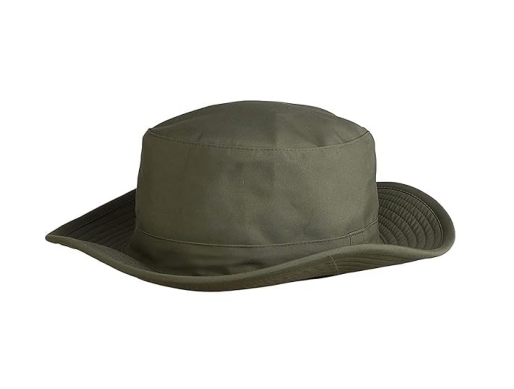


Image: shoe.jpg
Predictions: {'gender': 'Unisex', 'articleType': 'Casual Shoes', 'baseColour': 'Blue', 'season': 'Summer'}


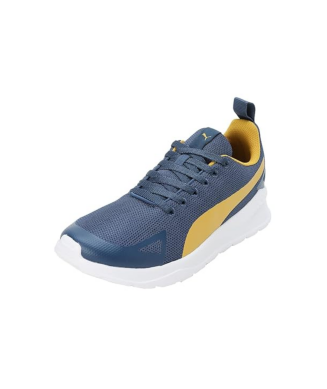


Image: tshirt.jpg
Predictions: {'gender': 'Men', 'articleType': 'Tshirts', 'baseColour': 'Blue', 'season': 'Summer'}


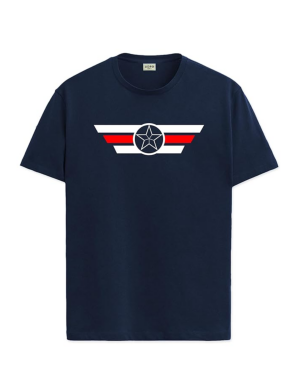


Image: watch.jpg
Predictions: {'gender': 'Women', 'articleType': 'Watches', 'baseColour': 'Grey', 'season': 'Winter'}


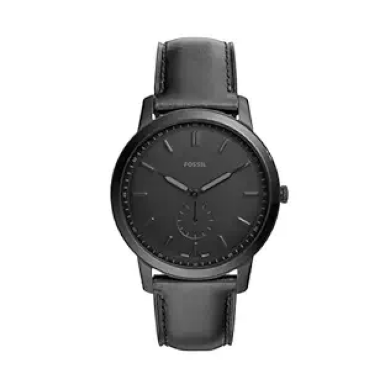

In [183]:
# Set model to eval mode
model.eval()

model_transform = transforms.Compose([transforms.ToTensor()])

# Loop through images
for img_path in predict_img_paths:
    # Load image
    p_img = Image.open(img_path).convert('RGB')
    input_tensor = model_transform(p_img).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
        preds = { 
            "gender": torch.argmax(outputs["gender"], dim=1).item(),
            "articleType": torch.argmax(outputs["articleType"], dim=1).item(),
            "baseColour": torch.argmax(outputs["baseColour"], dim=1).item(),
            "season": torch.argmax(outputs["season"], dim=1).item()
        }

    # Decode predictions
    decoded_preds = {}
    for key in preds:
        decoded_preds[key] = label_encoders[key].inverse_transform([preds[key]])[0]

    print(f"\nImage: {os.path.basename(img_path)}")
    print("Predictions:", decoded_preds)
    
    # Load the original image correctly
    original_img_path = os.path.join(prediction_imgs_folder, os.path.basename(img_path))
    img_for_plot = Image.open(original_img_path)  # FIXED: Use PIL.Image.open()
    
    # Plot
    plt.imshow(img_for_plot)
    plt.axis('off')
    plt.show()